In [1]:
file_num = '011'

In [2]:
import json
import pickle
import re
from glob import glob
from tqdm import tqdm
from pdb import set_trace as trace
from xfeat import Pipeline, SelectCategorical, LabelEncoder
import regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.metrics import log_loss

In [3]:
def removeZenkakuSpace(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('　', ' ')
    return df

def histEachFavs(df, col, height=3, aspect=4, title=''):
    for fav in sorted(df[FAV].unique()):
        sns.catplot(x=col,data=df.query(f"{FAV} == @fav"),kind='count',height=height, aspect=aspect)
        plt.title(f'{title} fav group:{fav}')
        
def getQueries(df, cols):
    assert type(cols) == str or type(cols) == list, 'cols is str or list'
    queries = []
    if type(cols) == str:
        queries = [f'{cols} == {flag}' for flag in sorted(df[cols].unique())]
    elif type(cols) == list:
        for col in cols:
            col_queries = [f'{col} == {flag}' for flag in sorted(df[col].unique())]
            if len(queries) == 0:
                queries = col_queries
            else:
                queries = [f"{q} & {col_queries[0]}" for q in queries] + [f'{q} & {col_queries[1]}' for q in queries]
            
    return queries

def columnUnique(df, col):
    return sorted(df[col].unique())

def histColumnsFavs(df, cols:list, height=3, aspect=6, title=''):
    queries = getQueries(df, cols)
    for query in queries:
        data = df.query(query)
        if len(data) == 0:
            continue
        sns.catplot(x=FAV,data=data,kind='count',height=height, aspect=aspect)
        plt.title(f'{title} {query}')
        
def histEachFavsByCategory(df, df_target, col):
    cats = sorted(df[col].unique())
    for cat in cats:
        fig, axes = plt.subplots(figsize=(30,10), ncols=3, nrows=2)
        for ax, fav in zip(axes.ravel(), favs):
            target_mask = (df[FAV] == fav) & (df[col] == cat)
            ax.hist(df_target.loc[target_mask], bins=100)
            ax.set_xlim(-1,df_target.max())
            ax.set_title(f'bgenre:{cat}, fav:{fav}, num={target_mask.sum()}')

In [4]:
def featureNumKeywords(df):
    num_keywords = np.vectorize(lambda x: len(x.split()))(df.keyword)
    return pd.DataFrame(data=num_keywords, columns=['num_keywords'])

def featureMaxSentenceLength(story):
    sentences_len = [len(sentence) for sentence in story.split('\n')]
    return max(sentences_len)
    
def featureNumIndent(story):
    return len(list(filter(lambda x: len(x) == 0 ,story.split('\n'))))
    
def featureStory(df):
    feature_df = pd.DataFrame()
    feature_df['num_sentence'] = df.story.str.count('\n')
    feature_df['max_sentence_len'] = np.vectorize(featureMaxSentenceLength)(df.story)
    feature_df['mean_sentence_len'] = (df.story.str.len() / (df.story.str.count('\n') +1)).astype('int')
    feature_df['num_indent'] = np.vectorize(featureNumIndent)(df.story)
    
    return feature_df
    
def concatDfs(dfs:list):
    concat_df = pd.DataFrame()
#     trace()
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        concat_df = pd.concat([concat_df, df], axis=1)
        
    return concat_df 

In [5]:
out_dir = '../output'
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
sub_df = pd.read_csv('../dataset/sample_submission.csv')
ID = 'ncode'
TARGET = 'fav_novel_cnt_bin'
favs = sorted(train_df[TARGET].unique())

# # train_df.userid = train_df.userid.astype('str')
# train_df.genre = train_df.genre.astype('str')
# test_df.userid = test_df.userid.astype('str')
# test_df.genre = test_df.genre.astype('str')
str_cols = ['title', 'story', 'keyword', 'writer']

In [6]:
train_df = removeZenkakuSpace(train_df, str_cols)
test_df = removeZenkakuSpace(test_df, str_cols)

In [7]:
all_df = pd.concat([train_df,test_df])
train_idx = len(train_df)

In [8]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(all_df)
all_df['writer'] = le_df['writer']

In [9]:
train_df.columns

Index(['ncode', 'general_firstup', 'title', 'story', 'keyword', 'userid',
       'writer', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 'isr15',
       'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni', 'pc_or_k',
       'fav_novel_cnt_bin'],
      dtype='object')

In [10]:
all_df.keyword = all_df.keyword.fillna('')

In [11]:
import datetime

dt_now = datetime.datetime.now()
all_df['past_days'] = all_df['general_firstup'].apply(lambda x: (dt_now - datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).days)

In [12]:
num_keyword_df = featureNumKeywords(all_df)

In [13]:
story_df = featureStory(all_df)

In [14]:
len(all_df)

48522

In [15]:
cat_cols = ['userid', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 'isr15', 'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni']

In [16]:
num_cols = ['past_days'] + list(num_keyword_df.columns) + list(story_df.columns)

In [17]:
feat_cols = cat_cols + num_cols

In [18]:
concat_df = concatDfs([all_df, num_keyword_df, story_df])
display(concat_df.shape)

(48522, 26)

In [19]:
train = concat_df.iloc[:35000, :]
val = concat_df.iloc[35000:train_idx, :]
test = concat_df.iloc[train_idx:, :]
print(train.shape, val.shape, test.shape)

(35000, 26) (5000, 26) (8522, 26)


In [20]:
train_x = train[feat_cols]
train_y = train[TARGET]
val_x = val[feat_cols]
val_y = val[TARGET]
test_x = test[feat_cols]
test_y = test[TARGET]
train_x.shape

(35000, 18)

In [21]:

SEED = 0

params = {
    'objective': 'multiclass',
    'num_classes': 5,
    'metric': 'multi_logloss',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 5000,
    "early_stopping_rounds": 100
}

train_data = lgbm.Dataset(train_x, label=train_y)
val_data = lgbm.Dataset(val_x, label=val_y)

model = lgbm.train(
    params,
    train_data, 
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data], 
    verbose_eval = 100,
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

/home/wsato/work/venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/wsato/work/venv/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['biggenre', 'end', 'genre', 'isbl', 'isgl', 'isr15', 'isstop', 'istenni', 'istensei', 'iszankoku', 'novel_type', 'userid']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/home/wsato/work/venv/lib/python3.8/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/wsato/work/venv/lib/python3.8/site-packages/lightgbm/basic.

Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.920829	valid's multi_logloss: 0.90429
[200]	train's multi_logloss: 0.839343	valid's multi_logloss: 0.846904
[300]	train's multi_logloss: 0.800125	valid's multi_logloss: 0.824676
[400]	train's multi_logloss: 0.776134	valid's multi_logloss: 0.813683
[500]	train's multi_logloss: 0.75934	valid's multi_logloss: 0.807562
[600]	train's multi_logloss: 0.745849	valid's multi_logloss: 0.804211
[700]	train's multi_logloss: 0.734512	valid's multi_logloss: 0.802301
[800]	train's multi_logloss: 0.724301	valid's multi_logloss: 0.801105
[900]	train's multi_logloss: 0.71474	valid's multi_logloss: 0.800381
[1000]	train's multi_logloss: 0.706002	valid's multi_logloss: 0.799795
[1100]	train's multi_logloss: 0.698021	valid's multi_logloss: 0.799544
[1200]	train's multi_logloss: 0.69045	valid's multi_logloss: 0.799511
Early stopping, best iteration is:
[1172]	train's multi_logloss: 0.692575	valid's multi_logloss: 0.

In [24]:
val_pred

array([[5.24113819e-01, 4.44273044e-01, 2.40200683e-02, 6.49761068e-03,
        1.09545808e-03],
       [7.44046683e-02, 5.22984026e-01, 2.06628708e-01, 1.49927161e-01,
        4.60554365e-02],
       [4.98142702e-01, 3.72812809e-01, 1.03118699e-01, 2.44148872e-02,
        1.51090283e-03],
       ...,
       [6.30992945e-01, 2.81334833e-01, 7.40254826e-02, 1.26544986e-02,
        9.92240745e-04],
       [6.72085004e-01, 2.83467573e-01, 3.58564854e-02, 7.51054253e-03,
        1.08039531e-03],
       [7.99925897e-01, 1.86794453e-01, 9.37653495e-03, 3.30213226e-03,
        6.00982370e-04]])

In [22]:
val_pred = model.predict(val_x, num_iteration=model.best_iteration)
val_pred_max = np.argmax(val_pred, axis=1)  # 最尤と判断したクラスの値にする
accuracy = sum(val_y == val_pred_max) / len(val_y)
print(accuracy)

0.6436


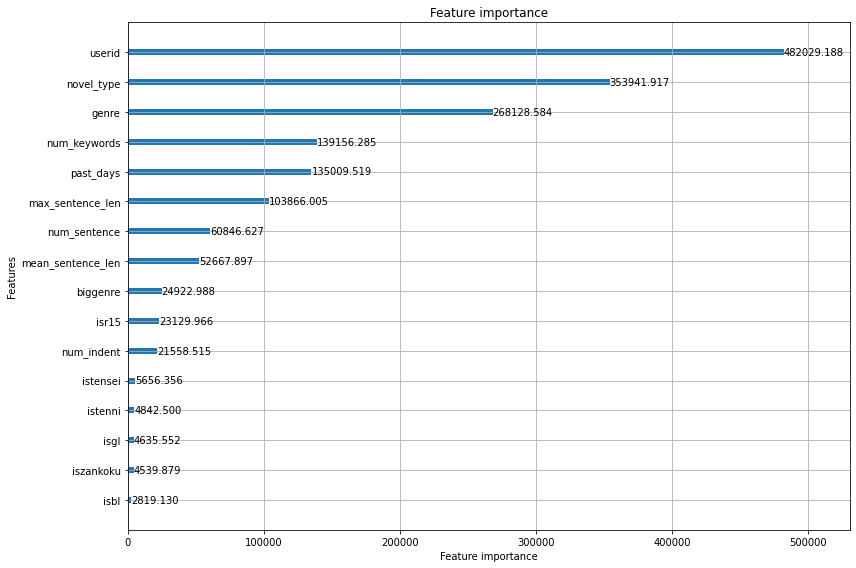

In [26]:
lgbm.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

(array([[2498.,    0., 1741.,    0.,    0.,  491.,    0.,  223.,    0.,
           47.],
        [3122.,    0., 1379.,    0.,    0.,  365.,    0.,  118.,    0.,
           16.]]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 2 BarContainer objects>)

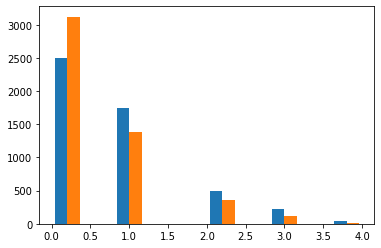

In [23]:
plt.hist([val_y, val_pred_max])

In [27]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)
sub_df.iloc[:, 1:] = test_pred
sub_df.to_csv(f'../output/test_submission_{file_num}.csv', index=False)